In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import pickle 
import cv2
import numpy as np
%matplotlib inline

## Exploring data 

We are using the KITTI and GTI dataset with following directory structure

vehicles ---
         --- GTI_Far/  GTI_Left/  GTI_MiddleClose/  GTI_Right/  KITTI_extracted/

non-vehicles----
          ---  Extras/  GTI/



### Here is a sample 



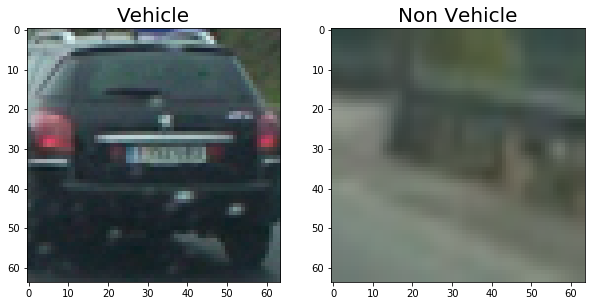

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
vehicle = mpimg.imread("vehicles/GTI_Far/image0816.png")
ax1.imshow(vehicle)
ax1.set_title('Vehicle', fontsize=20)
non_vehicle = mpimg.imread("non-vehicles/GTI/image9.png")
ax2.imshow(non_vehicle)
ax2.set_title('Non Vehicle', fontsize=20)

## Now, let's train classifier
We will using SVM for this 

In [37]:
vehicles = glob("vehicles/*/*.png",recursive=True)
shuffle(vehicles)
non_vehicles = glob("non-vehicles/*/*.png",recursive=True)
shuffle(non_vehicles)

print("No of vehicle sample is {}".format(len(vehicles)))
print("No of Non - vehicle sample is {}".format(len(non_vehicles)))

print("Splitting data ...")

# For splitting data we use Paleto's principle or 80:20 rule
# 80 % data for training and 20 % data for testing our classifier 
rand_state = np.random.randint(0,100)
vehicles_train, vehicles_test = train_test_split(vehicles, train_size = 0.8,random_state=rand_state)
shuffle(vehicles_train)
shuffle(vehicles_test)
non_vehicles_train,non_vehicles_test = train_test_split(non_vehicles,train_size=0.8,random_state=rand_state)
shuffle(non_vehicles_test)
shuffle(non_vehicles_train)

print("\n---- Vehicles -------\n")
print("No of training vehicle sample is {}".format(len(vehicles_train)))
print("No of test vehicle sample is {}".format(len(vehicles_test)))

print("\n---- Non-Vehicles----\n")
print("No of training non vehicle sample is {}".format(len(non_vehicles_train)))
print("No of test non vehicle sample is {}".format(len(non_vehicles_test)))

print("Saving data ...")
pickle_dict = {}
vehicle_dict = {"train" : vehicles_train, "test" : vehicles_test}
non_vehicle_dict = {"train" : non_vehicles_train, "test" : non_vehicles_test}
pickle_dict["car"] = vehicle_dict
pickle_dict["non_car"] = non_vehicle_dict

with open('data.pickle', 'wb') as file:
    pickle.dump(pickle_dict, file)
print("Saved data ...")

No of vehicle sample is 8792
No of Non - vehicle sample is 8968
Splitting data ...

---- Vehicles -------

No of training vehicle sample is 7033
No of test vehicle sample is 1759

---- Non-Vehicles----

No of training non vehicle sample is 7174
No of test non vehicle sample is 1794
Saving data ...
Saved data ...


### Data seems to be balanced with only ~ 210 more non-vehicles, so our data is fairly balanced. With that let's proceed to train our classifier. We are shuffling and saving data list as pickle file, so that we don't have to do shuffling and splitting everytime

## Before we get to Training our classifier, let's talk about features we will be using. I promise, it won't be too long


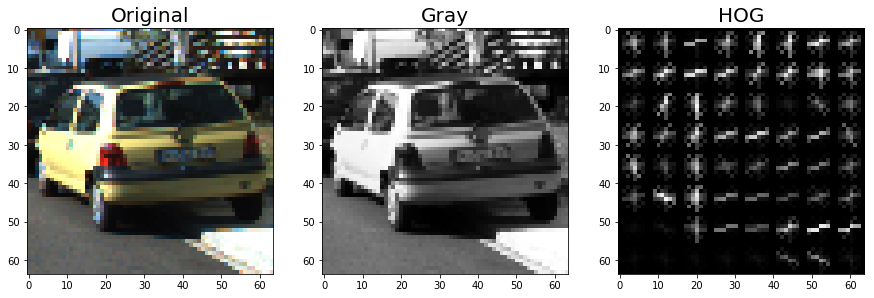

In [33]:
from lesson_functions import get_hog_features
with open('data.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 
img_path = data['vehicle']['train'][np.random.randint(0,len(data['vehicle']['train']))]
img = mpimg.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,10))
vehicle = mpimg.imread("vehicles/GTI_Far/image0816.png")
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
non_vehicle = mpimg.imread("non-vehicles/GTI/image9.png")
ax2.imshow(gray,cmap='Greys_r')
ax2.set_title('Gray', fontsize=20)
_,hog_image = get_hog_features(gray,9,8,2,vis=True, feature_vec=True)
ax3.set_title('HOG',fontsize=20)
ax3.imshow(hog_image,cmap='Greys_r')

## HOG Features and many other features such as spatial features are very useful for training classifier as they help distinguish features between a car and a non car

In [3]:
from sklearn.svm import LinearSVC
from lesson_functions import extract_features
import time
with open('data.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 

## Local Hyper Parameters
colorspace = 'HLS'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0

t1 = time.time()
car_train = data['car']['train']
car_train_features = extract_features(car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
non_car_train = data['non_car']['train']
non_car_train_features = extract_features(non_car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
car_test = data['car']['test']
non_car_test = data['car']['test']
car_test_features = extract_features(car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
non_car_test_features = extract_features(non_car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1,2),'Seconds to extract HOG Features ..')


car_features_dict= {'train' : car_train_features, 'test' : car_test_features}
non_car_features_dict = {'train' : non_car_train_features, 'test' : non_car_test_features}
feature_dict = {'car' : car_features_dict, 'non_car' : non_car_features_dict}

print("Saving data ...")
with open('features.pickle', 'wb') as file:
    pickle.dump(feature_dict, file)
print("Saved data ...")

333.46 Seconds to extract HOG Features ..
Saving data ...
Saved data ...


In [12]:

X_train = np.vstack((car_train_features,non_car_train_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_train)

X_test = np.vstack((car_test_features,non_car_test_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_test)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_test)

y_train = np.hstack((np.ones(len(car_train_features)),np.zeros(len(non_car_train_features))))
y_test = np.hstack((np.ones(len(car_test_features)),np.zeros(len(non_car_test_features))))
print("Training ....")
svc = LinearSVC()
t1 = time.time()
svc.fit(X_train,y_train)
t2 = time.time()
print(round(t2-t1,2),"Seconds to train SVC ...")
print("Test accuracy of SVC = ",round(svc.score(X_test,y_test),4))


t1 = time.time()
n_predict = 10
print("My SVC predicts: ",svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ',y_test[0:n_predict])
t2 = time.time()

print(round(t2-t1,5),'Seconds to predict', n_predict,'labels with SVC')

Training ....
329.12 Seconds to train SVC ...
Test accuracy of SVC =  0.7793
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.01224 Seconds to predict 10 labels with SVC
